<a href="https://colab.research.google.com/github/akshray/tensorflow_practice/blob/master/Transfer_Learning_mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [2]:
tf.__version__

'2.0.0'

In [3]:
device = tf.test.gpu_device_name()

if device != '/device:GPU:0':
  raise SystemError('not found')
print('found at: {}'.format(device))

found at: /device:GPU:0


In [4]:
!pip install --upgrade tensorflow-hub
!pip install -q -U tensorflow_datasets

Requirement already up-to-date: tensorflow-hub in /usr/local/lib/python3.6/dist-packages (0.7.0)


In [0]:
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pylab as plt


Loading dataset using tfds

In [6]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 20))

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples) = splits

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


In [7]:
info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=2.0.1,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    urls=['https://www.microsoft.com/en-us/download/details.aspx?id=54765'],
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    year

In [0]:
def format_image(image, label):
  # `hub` image modules exepct their data normalized to the [0,1] range.
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return  image, label

total_num_examples = info.splits['train'].num_examples

BATCH_SIZE = 32
IMAGE_RES = 224

train_batches      = train_examples.cache().shuffle(total_num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

<h1>Preparation of the covolutional base (to extract features)<h1>

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [0]:
feature_extractor.trainable = False

Combining the base with the classification layer

In [11]:
model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.compile(
  optimizer='adam', 
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])


In [13]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 44s 76ms/step - loss: 0.0538 - accuracy: 0.9814 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
582/582 [==============================] - 23s 39ms/step - loss: 0.0287 - accuracy: 0.9903 - val_loss: 0.0338 - val_accuracy: 0.9875
Epoch 3/10
582/582 [==============================] - 23s 40ms/step - loss: 0.0255 - accuracy: 0.9921 - val_loss: 0.0388 - val_accuracy: 0.9858
Epoch 4/10
582/582 [==============================] - 23s 40ms/step - loss: 0.0213 - accuracy: 0.9924 - val_loss: 0.0341 - val_accuracy: 0.9884
Epoch 5/10
582/582 [==============================] - 23s 39ms/step - loss: 0.0194 - accuracy: 0.9941 - val_loss: 0.0351 - val_accuracy: 0.9875
Epoch 6/10
582/582 [==============================] - 23s 39ms/step - loss: 0.0170 - accuracy: 0.9944 - val_loss: 0.0484 - val_accuracy: 0.9845
Epoch 7/10
582/582 [==============================] - 23s 40ms/step - loss: 0.0153 - accuracy: 0.9947 - val_loss: 0.0339 - val_a

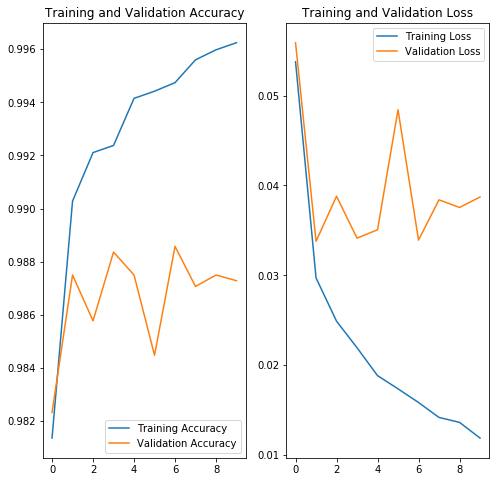

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Save as keras model

In [15]:
import time
t = time.time()

keras_model_path = "./{}.h5".format(int(t))
print(keras_model_path)

model.save(keras_model_path)

./1575371777.h5


Save as SavedModel

In [16]:
t = time.time()
savemodel_export_path = "./{}".format(int(t))
print(savemodel_export_path)

tf.saved_model.save(model, savemodel_export_path)

./1575371777
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./1575371777/assets


INFO:tensorflow:Assets written to: ./1575371777/assets


In [17]:
!ls

1575371777  1575371777.h5  sample_data


In [18]:
!ls ./1574599634/

ls: cannot access './1574599634/': No such file or directory
